# Machine Learning Modeling 
* `non-stationary` & `highly-correlated` 

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd 
import numpy as np
pd.set_option("max_rows", 500)
pd.set_option("max_columns", 500)
pd.set_option('float_format', '{:f}'.format)

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt 

plt.style.use('seaborn')
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)


import dataload

import os 
import random
import datetime
from tqdm import tqdm 
from functools import reduce

# modeling 
from tslearn.clustering import TimeSeriesKMeans

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

import shap 

In [4]:
nonst_high = pd.read_csv("nonst_high_0616.csv", encoding="cp949")
weather = pd.read_csv("weather_final2.csv", encoding="cp949")
loc_weight = pd.read_csv("population_wieght.csv", encoding="cp949")

print(nonst_high.shape, weather.shape, loc_weight.shape)

print("*", nonst_high.sm_cat.nunique())
nonst_high.head()

((67, 367), (1303336, 52), (11680, 29))

In [161]:
nonst_high['date'] = nonst_high['date'].progress_apply(lambda x : pd.to_datetime(str(x), format='%Y-%m-%d'))

100%|██████████| 1179438/1179438 [01:27<00:00, 13537.65it/s]


In [12]:
tqdm.pandas()
nonst_high['date'] = nonst_high['date'].progress_apply(lambda x : pd.to_datetime(str(x), format='%Y-%m-%d'))
weather['날짜'] = weather['날짜'].progress_apply(lambda x : pd.to_datetime(str(x), format='%Y-%m-%d'))
weather = weather.rename(columns={"날짜" : "date"})

100%|██████████| 11680/11680 [00:00<00:00, 14509.01it/s]


# TimeSeries Clustering 

In [172]:
nonst_high['year'] = nonst_high['date'].progress_apply(lambda x : x.year)
buy_2018 = nonst_high[nonst_high.year==2018][['date', 'big_cat', 'sm_cat', 'qty']]
buy_2019 = nonst_high[nonst_high.year==2019][['date', 'big_cat', 'sm_cat', 'qty']]
nonst_high = nonst_high.drop('year', axis=1)

buy_2018.shape, buy_2019.shape

100%|██████████| 1179438/1179438 [00:04<00:00, 271024.22it/s]


((586427, 4), (593011, 4))

In [173]:
buy_2018["date"] = buy_2018["date"] + datetime.timedelta(days=-1)
buy_2018["date"] = buy_2018["date"].progress_apply(lambda x : x.replace(year=2018, month=12, day=31) if x==datetime.date(2017, 12, 31) else x)

100%|██████████| 586427/586427 [00:02<00:00, 253358.20it/s]


In [174]:
buy_2018.date.nunique()

365

In [175]:
buy_2018["date"] = buy_2018["date"].apply(lambda x : str(x)[5:])
buy_2019["date"] = buy_2019["date"].apply(lambda x : str(x)[5:])

In [176]:
buy_2018 = pd.pivot_table(buy_2018, index="sm_cat", columns="date", values="qty")
buy_2019 = pd.pivot_table(buy_2019, index="sm_cat", columns="date", values="qty")

print(buy_2018.shape, buy_2019.shape)

buy_2018 = buy_2018.fillna(0)
buy_2019 = buy_2019.fillna(0)

(176, 365) (176, 365)


In [177]:
buy_2018.head()

date,01-01 00:00:00,01-02 00:00:00,01-03 00:00:00,01-04 00:00:00,01-05 00:00:00,01-06 00:00:00,01-07 00:00:00,01-08 00:00:00,01-09 00:00:00,01-10 00:00:00,01-11 00:00:00,01-12 00:00:00,01-13 00:00:00,01-14 00:00:00,01-15 00:00:00,01-16 00:00:00,01-17 00:00:00,01-18 00:00:00,01-19 00:00:00,01-20 00:00:00,01-21 00:00:00,01-22 00:00:00,01-23 00:00:00,01-24 00:00:00,01-25 00:00:00,01-26 00:00:00,01-27 00:00:00,01-28 00:00:00,01-29 00:00:00,01-30 00:00:00,01-31 00:00:00,02-01 00:00:00,02-02 00:00:00,02-03 00:00:00,02-04 00:00:00,02-05 00:00:00,02-06 00:00:00,02-07 00:00:00,02-08 00:00:00,02-09 00:00:00,02-10 00:00:00,02-11 00:00:00,02-12 00:00:00,02-13 00:00:00,02-14 00:00:00,02-15 00:00:00,02-16 00:00:00,02-17 00:00:00,02-18 00:00:00,02-19 00:00:00,02-20 00:00:00,02-21 00:00:00,02-22 00:00:00,02-23 00:00:00,02-24 00:00:00,02-25 00:00:00,02-26 00:00:00,02-27 00:00:00,02-28 00:00:00,03-01 00:00:00,03-02 00:00:00,03-03 00:00:00,03-04 00:00:00,03-05 00:00:00,03-06 00:00:00,03-07 00:00:00,03-08 00:00:00,03-09 00:00:00,03-10 00:00:00,03-11 00:00:00,03-12 00:00:00,03-13 00:00:00,03-14 00:00:00,03-15 00:00:00,03-16 00:00:00,03-17 00:00:00,03-18 00:00:00,03-19 00:00:00,03-20 00:00:00,03-21 00:00:00,03-22 00:00:00,03-23 00:00:00,03-24 00:00:00,03-25 00:00:00,03-26 00:00:00,03-27 00:00:00,03-28 00:00:00,03-29 00:00:00,03-30 00:00:00,03-31 00:00:00,04-01 00:00:00,04-02 00:00:00,04-03 00:00:00,04-04 00:00:00,04-05 00:00:00,04-06 00:00:00,04-07 00:00:00,04-08 00:00:00,04-09 00:00:00,04-10 00:00:00,04-11 00:00:00,04-12 00:00:00,04-13 00:00:00,04-14 00:00:00,04-15 00:00:00,04-16 00:00:00,04-17 00:00:00,04-18 00:00:00,04-19 00:00:00,04-20 00:00:00,04-21 00:00:00,04-22 00:00:00,04-23 00:00:00,04-24 00:00:00,04-25 00:00:00,04-26 00:00:00,04-27 00:00:00,04-28 00:00:00,04-29 00:00:00,04-30 00:00:00,05-01 00:00:00,05-02 00:00:00,05-03 00:00:00,05-04 00:00:00,05-05 00:00:00,05-06 00:00:00,05-07 00:00:00,05-08 00:00:00,05-09 00:00:00,05-10 00:00:00,05-11 00:00:00,05-12 00:00:00,05-13 00:00:00,05-14 00:00:00,05-15 00:00:00,05-16 00:00:00,05-17 00:00:00,05-18 00:00:00,05-19 00:00:00,05-20 00:00:00,05-21 00:00:00,05-22 00:00:00,05-23 00:00:00,05-24 00:00:00,05-25 00:00:00,05-26 00:00:00,05-27 00:00:00,05-28 00:00:00,05-29 00:00:00,05-30 00:00:00,05-31 00:00:00,06-01 00:00:00,06-02 00:00:00,06-03 00:00:00,06-04 00:00:00,06-05 00:00:00,06-06 00:00:00,06-07 00:00:00,06-08 00:00:00,06-09 00:00:00,06-10 00:00:00,06-11 00:00:00,06-12 00:00:00,06-13 00:00:00,06-14 00:00:00,06-15 00:00:00,06-16 00:00:00,06-17 00:00:00,06-18 00:00:00,06-19 00:00:00,06-20 00:00:00,06-21 00:00:00,06-22 00:00:00,06-23 00:00:00,06-24 00:00:00,06-25 00:00:00,06-26 00:00:00,06-27 00:00:00,06-28 00:00:00,06-29 00:00:00,06-30 00:00:00,07-01 00:00:00,07-02 00:00:00,07-03 00:00:00,07-04 00:00:00,07-05 00:00:00,07-06 00:00:00,07-07 00:00:00,07-08 00:00:00,07-09 00:00:00,07-10 00:00:00,07-11 00:00:00,07-12 00:00:00,07-13 00:00:00,07-14 00:00:00,07-15 00:00:00,07-16 00:00:00,07-17 00:00:00,07-18 00:00:00,07-19 00:00:00,07-20 00:00:00,07-21 00:00:00,07-22 00:00:00,07-23 00:00:00,07-24 00:00:00,07-25 00:00:00,07-26 00:00:00,07-27 00:00:00,07-28 00:00:00,07-29 00:00:00,07-30 00:00:00,07-31 00:00:00,08-01 00:00:00,08-02 00:00:00,08-03 00:00:00,08-04 00:00:00,08-05 00:00:00,08-06 00:00:00,08-07 00:00:00,08-08 00:00:00,08-09 00:00:00,08-10 00:00:00,08-11 00:00:00,08-12 00:00:00,08-13 00:00:00,08-14 00:00:00,08-15 00:00:00,08-16 00:00:00,08-17 00:00:00,08-18 00:00:00,08-19 00:00:00,08-20 00:00:00,08-21 00:00:00,08-22 00:00:00,08-23 00:00:00,08-24 00:00:00,08-25 00:00:00,08-26 00:00:00,08-27 00:00:00,08-28 00:00:00,08-29 00:00:00,08-30 00:00:00,08-31 00:00:00,09-01 00:00:00,09-02 00:00:00,09-03 00:00:00,09-04 00:00:00,09-05 00:00:00,09-06 00:00:00,09-07 00:00:00,09-08 00:00:00,09-09 00:00:00,09-10 00:00:00,09-11 00:00:00,09-12 00:00:00,09-13 00:00:00,09-14 00:00:00,09-15 00:00:00,09-16 00:00:00,09-17 00:00:00,09-18 00:00:00,09-19 00:00:00,09-20 00:00:00,09-21 00:00:00,09-22 00:00:00,09-23 00:00:00,09-24

## 1. 데이터 정규화 

In [178]:
def normalize_df(df) : 
    avg_lst = []; std_lst = []
    for idx, row in tqdm(df.iterrows()):
        avg_lst.append(row.mean())
        std_lst.append(row.std())

    df['avg'] = avg_lst
    df['std'] = std_lst


    for i in tqdm(range(len(df))):
        for j in range(365):
            df.iloc[i,j] = (df.iloc[i,j] - df.iloc[i,365])/df.iloc[i,366] 

    df = df.drop(['avg','std'], axis=1)
    return df 

In [179]:
buy_2018 = normalize_df(buy_2018)
buy_2019 = normalize_df(buy_2019)

176it [00:00, 7037.76it/s]
100%|██████████| 176/176 [00:09<00:00, 17.96it/s]
176it [00:00, 8348.38it/s]
100%|██████████| 176/176 [00:09<00:00, 18.33it/s]


In [182]:
ts = (buy_2018 + buy_2019)/2
ts.shape

(176, 365)

## 2. 최적 k 찾기 

In [181]:
def visualize_elbowmethod(data, param_init='random', param_n_init=10, param_max_iter=300):
    distortions = []
    for i in tqdm(range(2, 7)): 
        ts_clustering = TimeSeriesKMeans(n_clusters=i, max_iter=param_max_iter, random_state=1234, metric = 'dtw')
        ts_clustering.fit(data)
        distortions.append(ts_clustering.inertia_)

    plt.plot(range(2, 7), distortions, marker='o')
    plt.xlabel('Number of Cluster')
    plt.ylabel('Distortion')
    plt.show()

100%|██████████| 5/5 [03:06<00:00, 37.38s/it]


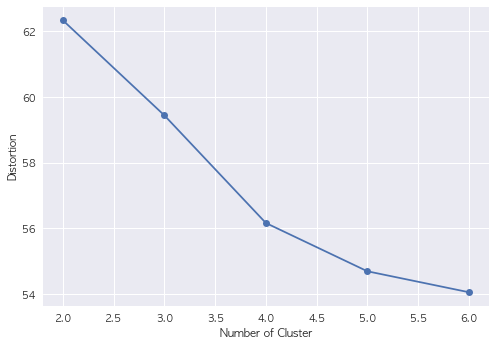

CPU times: user 8min 56s, sys: 1min 12s, total: 10min 8s
Wall time: 3min 6s


In [185]:
%time  visualize_elbowmethod(ts)

## 3. TimeSeries K-means Clustering 

In [186]:
model1 = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=300, random_state=1234, n_jobs=-1)

for i in tqdm(range(len(ts))) : 
    model1.fit(ts)

100%|██████████| 176/176 [1:39:57<00:00, 34.08s/it]


In [187]:
ts_result = pd.DataFrame({
    'sm_cat' : ts.index, 
    'cluster' : model1.labels_
})

In [188]:
ts_result.cluster.value_counts()

0    66
3    42
1    41
2    27
Name: cluster, dtype: int64

In [189]:
# cluster 0 : 여름 (66)
ts_result[ts_result.cluster==0]

,sm_cat,cluster
1,감/홍시,0
4,감자,0
6,건대추,0
7,건포도,0
12,계란,0
13,고추/피망/파프리카,0
15,공기정화 용품,0
27,기타 주스류,0
28,김치류,0
32,남성 선케어,0


In [190]:
# cluster 1 
ts_result[ts_result.cluster==1]

,sm_cat,cluster
10,견과류 땅콩,1
16,과채 음료/주스,1
19,기능성 아이케어 화장품,1
22,기초 화장용 로션,1
23,기초 화장용 미스트,1
24,기초 화장용 에센스,1
30,남성 로션,1
31,남성 메이크업,1
33,남성 세트,1
34,남성 쉐이빙,1


In [191]:
# cluster 2 
ts_result[ts_result.cluster==2]

,sm_cat,cluster
5,갓김치,2
9,견과류,2
20,기능성 영양보습 화장품,2
42,다이어트보조식,2
44,닭 양념육,2
46,더치커피,2
64,바나나/파인애플/망고,2
66,바디 세트,2
72,백김치,2
76,벽걸이형 냉온풍기,2


In [192]:
# cluster 3 
ts_result[ts_result.cluster==3]

,sm_cat,cluster
0,가열식 가습기,3
2,감귤/한라봉/오렌지,3
3,감말랭이,3
8,게장류,3
11,견과류 밤,3
14,곡물차,3
17,국내산 돈육,3
18,굴 생물,3
21,기능성 화장품 세트,3
25,기초 화장용 오일/앰플,3


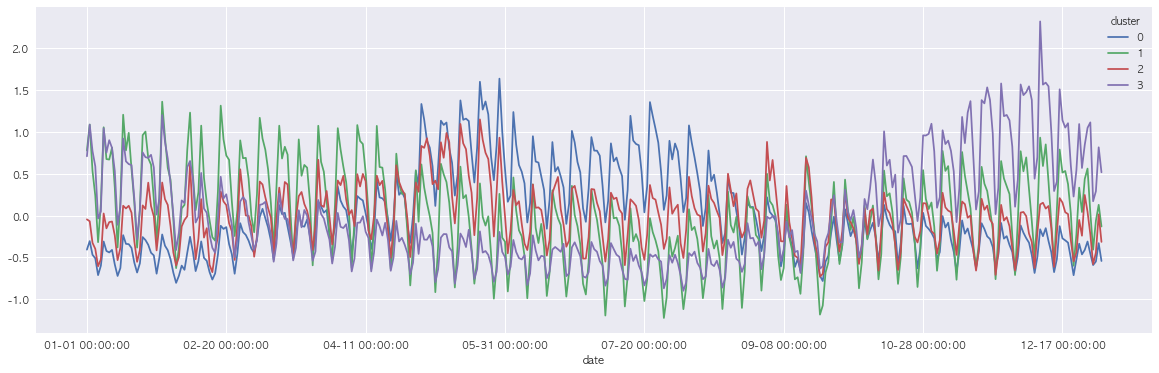

In [193]:
ts["cluster"] = model1.labels_

plt.rcParams["figure.figsize"]=(20,6)
ts.groupby(['cluster']).mean().T.plot()
plt.show()

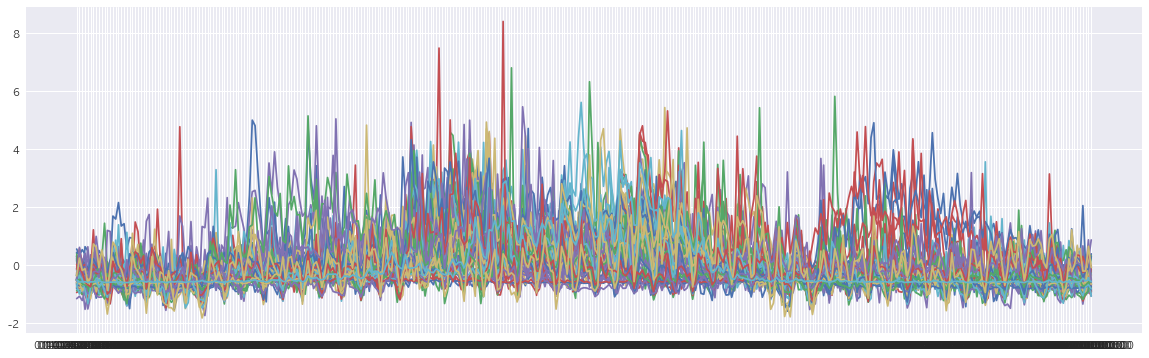

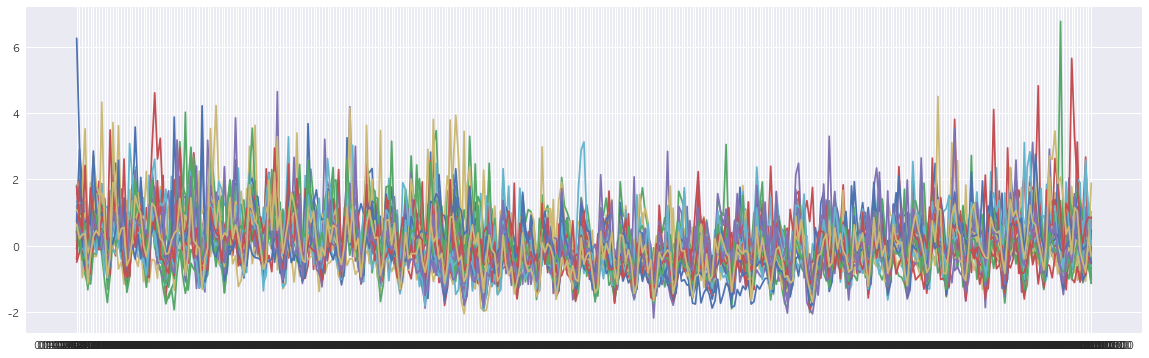

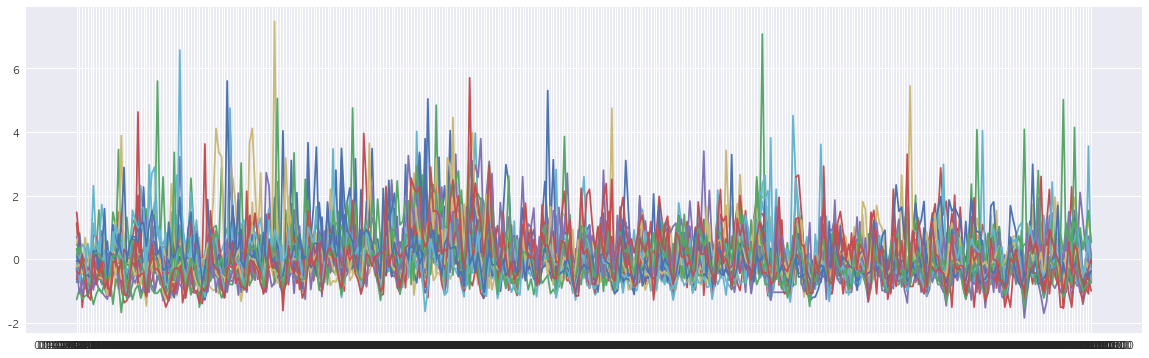

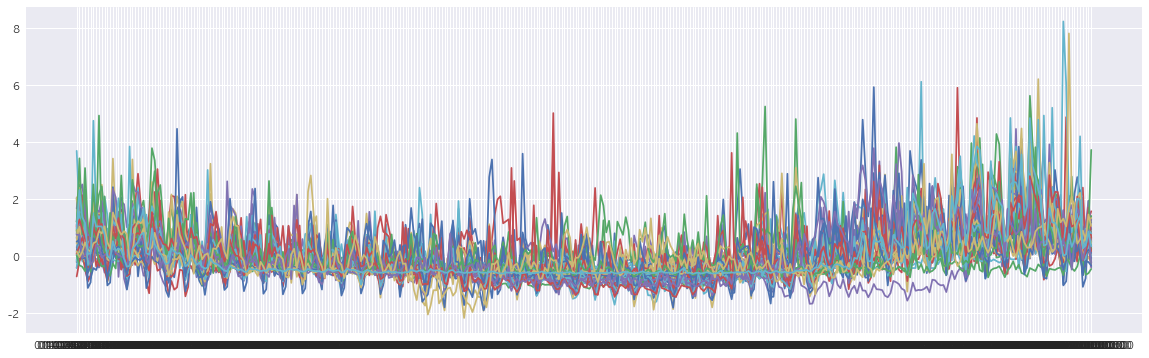

In [194]:
for i in range(4):
    clusters = ts[ts['cluster']==i]
    clusters.drop(['cluster'], axis=1, inplace=True)
    plt.figure(figsize=(20,6))
    plt.plot(clusters.T)
    plt.show

In [195]:
ts["cluster"] = model1.labels_
ts.to_csv("tsclustering_0617.csv", encoding='cp949')

In [200]:
ts = pd.read_csv("tsclustering_0617.csv", encoding='cp949')

# Modeling 

In [100]:
def region_weather(loc):
    weather_true = weather.drop(['연', '월', '일', '분기', '요일', '공휴일명', '공휴일여부', '주말여부', '계절', 'year', 'month'], axis=1) 
    weather1 = pd.pivot_table(weather_true[weather_true['지역'] == loc], index='date', columns='지역').reset_index(level=0)
    weather1.columns = weather1.columns.get_level_values(0)
    return weather1

In [203]:
def cluster_df(big_cat, product_cat) : 
    
    '''
    big_cat : TimeSeries Clustering 결과 파일 (pivot table 형태의 dataframe)
    product_cat : big_category 에 해당되는 dataframe 
    '''
    
    cluster0 = big_cat[big_cat["cluster"] == 0] 
    cluster1 = big_cat[big_cat["cluster"] == 1]
    cluster2 = big_cat[big_cat["cluster"] == 2]
    cluster3 = big_cat[big_cat["cluster"] == 3]
    
    cluster0 = list(cluster0['sm_cat']) 
    cluster1 = list(cluster1['sm_cat']) 
    cluster2 = list(cluster2['sm_cat']) 
    cluster3 = list(cluster3['sm_cat']) 
    
    product_cat = product_cat.rename(columns = {'PM10' : 'PM10_index', 'PM25' : 'PM25_index'})
    
    big_c0 = product_cat[product_cat['sm_cat'].isin(cluster0)].reset_index(drop=True)
    big_c1 = product_cat[product_cat['sm_cat'].isin(cluster1)].reset_index(drop=True)
    big_c2 = product_cat[product_cat['sm_cat'].isin(cluster2)].reset_index(drop=True)
    big_c3 = product_cat[product_cat['sm_cat'].isin(cluster3)].reset_index(drop=True)
    
    return big_c0, big_c1, big_c2, big_c3

In [204]:
bty_c0, bty_c1, bty_c2, bty_c3 = cluster_df(ts, nonst_high)
bty_c0.shape, bty_c1.shape, bty_c2.shape, bty_c3.shape

((440102, 52), (288703, 52), (169673, 52), (280960, 52))

In [337]:
print(nonst_high.shape)
nonst_high.head()

(1179438, 52)


,date,sex,big_cat,sm_cat,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,공휴일여부,주말여부,연_2019,월_2,월_3,월_4,월_5,월_6,월_7,월_8,월_9,월_10,월_11,월_12,분기_2,분기_3,분기_4,요일_1,요일_2,요일_3,요일_4,요일_5,요일_6,계절_1,계절_2,계절_3,age_20,age_30,age_40,age_50
0,2018-01-01,1,냉난방가전,가열식 가습기,1.000000,24.759610,10.693870,4.091370,0.000000,0.000000,0.044400,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,2018-01-01,1,냉난방가전,가열식 가습기,0.000000,17.938930,12.429690,6.352940,0.000000,0.512820,0.424170,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,2018-01-01,1,냉난방가전,가열식 가습기,3.000000,11.070550,13.022490,4.880370,0.000000,0.406500,0.000000,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,2018-01-01,1,냉난방가전,가열식 가습기,0.000000,12.605040,11.690800,4.533500,1.219510,0.909090,0.000000,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,2018-01-01,1,냉난방가전,가열식 가습기,0.000000,4.255310,13.927120,5.478870,0.000000,0.000000,0.000000,0.885198,5.464146,-2.880740,0.000000,0.000000,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [339]:
nonst_high[nonst_high["qty"] == 0].shape

(191875, 52)

In [205]:
# sm_cat one hot encoding 
bty_c0 = pd.get_dummies(bty_c0, columns=['sm_cat'], drop_first = True)
bty_c1 = pd.get_dummies(bty_c1, columns=['sm_cat'], drop_first = True)
bty_c2 = pd.get_dummies(bty_c2, columns=['sm_cat'], drop_first = True)
bty_c3 = pd.get_dummies(bty_c3, columns=['sm_cat'], drop_first = True)

bty_c0.shape, bty_c1.shape, bty_c2.shape, bty_c3.shape

((440102, 116), (288703, 91), (169673, 77), (280960, 92))

In [123]:
def loc_df(cluster) : 
    
    '''
    - 수도권: 서울
    - 강원: 강릉
    - 경북: 대구
    - 경남: 부산
    - 전남: 광주
    - 전북: 전주 
    - 충남: 대전
    - 충북: 청주 
    - 제주: 제주
    '''
    
    c0_1 = cluster.merge(region_weather('서울'), on="date", how='left')
    c0_2 = cluster.merge(region_weather('강릉'), on="date", how='left')
    c0_3 = cluster.merge(region_weather('대구'), on="date", how='left')
    c0_4 = cluster.merge(region_weather('부산'), on="date", how='left')
    c0_5 = cluster.merge(region_weather('광주'), on="date", how='left')
    c0_6 = cluster.merge(region_weather('전주'), on="date", how='left')
    c0_7 = cluster.merge(region_weather('대전'), on="date", how='left')
    c0_8 = cluster.merge(region_weather('청주'), on="date", how='left')
    c0_9 = cluster.merge(region_weather('제주'), on="date", how='left')  
    
    return c0_1, c0_2, c0_3, c0_4, c0_5, c0_6, c0_7, c0_8, c0_9

In [25]:
def sampling(data):
    
    # 랜덤으로 요일 선택
    np.random.seed(1234)
    sample_day = []; sample_idx = []
    count = 730//7 
    day_list = day_list = [1,2,3,4,5,6,7]
    sample_list = [random.choice(day_list) for i in range(count)]

    # 랜덤으로 선택된 요일의 날짜
    start = datetime.datetime(2018, 1, 1)
    for days in sample_list:
        sample_day.append(start + datetime.timedelta(days = days))
        start = start + datetime.timedelta(weeks = 1)

    # 샘플링
    for date in sample_day:
        sample_idx.extend(data[data['date']==date].index)
        
    all_idx = data.index.tolist()
    train_idx = list(set(all_idx) - set(sample_idx))
    
    return data.iloc[train_idx].reset_index(drop=True), data.iloc[sample_idx].reset_index(drop=True)

In [329]:
def df_preprocessing(train, test) : 
    train = train.drop(['date', 'big_cat'], axis=1) ; test = test.drop(['date', 'big_cat'], axis=1)

    # X, y 
    X_train , y_train = train.drop('qty', axis=1), train.qty 
    X_test , y_test = test.drop('qty', axis=1), test.qty 
    
    # continuous / discrete 
    dummy = list(X_train.columns[X_train.columns.str.contains("연|월|분기|요일|공휴일여부|주말여부|계절|age|sm_cat_|강수여부|폭염여부|sex")])
    train_continuous = X_train.drop(dummy, axis=1) ; test_continuous = X_test.drop(dummy, axis=1) 
    train_discrete = X_train[dummy] ; test_discrete = X_test[dummy]
    
    # standardization 
    std_scaler = StandardScaler() 
    train_std = std_scaler.fit_transform(train_continuous) ; test_std = std_scaler.transform(test_continuous)
    train_std = pd.DataFrame(train_std, columns = train_continuous.columns) ; test_std = pd.DataFrame(test_std, columns = test_continuous.columns)
    
    # concat dummy variable 
    train_std = pd.concat([train_std, train_discrete], axis=1) ; test_std = pd.concat([test_std, test_discrete], axis=1)
        
    return train_std, y_train, test_std, y_test

# Modeling 

In [223]:
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

## 1. Cluster0 : 겨울 

In [229]:
def location_ensemble(df, model, shapvalue=False) : 
    train, test = sampling(df)
    train1, train2, train3, train4, train5, train6, train7, train8, train9 = loc_df(train) 
    test1, test2, test3, test4, test5, test6, test7, test8, test9 = loc_df(test) 
    
    if not train1.shape==train2.shape==train3.shape==train4.shape==train5.shape==train6.shape==train7.shape==train8.shape==train9.shape : 
        raise Exception("Check Again!")
    if not test1.shape==test2.shape==test3.shape==test4.shape==test5.shape==test6.shape==test7.shape==test8.shape==test9.shape : 
        raise Exception("Check Again!")

    print("===== Finish Data Preprocessing =====")
    print()
       
        
    # 1. 서울 
    X_train1, y_train1, X_test1, y_test1 = df_preprocessing(train1, test1)
    
    model1 = model
    model1.fit(X_train1, y_train1)
    y_pred1 = model1.predict(X_test1)
    
    fe1 = pd.DataFrame({'col' : X_train1.columns, 'feature importance' : model1.feature_importances_})
    fe1 = fe1[~fe1.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe1 = fe1.set_index('col').squeeze(axis=1)
    
    if shapvalue : 
        explainer1 = shap.TreeExplainer(model1)
        shap_values1 = explainer1.shap_values(X_train1)
        
    
    print("* Finish 서울 *")
    
    
    # 2. 강원 
    X_train2, y_train2, X_test2, y_test2 = df_preprocessing(train2, test2)
    
    model2 = model
    model2.fit(X_train2, y_train2)
    y_pred2 = model2.predict(X_test2)    
    
    fe2 = pd.DataFrame({'col' : X_train2.columns, 'feature importance' : model2.feature_importances_})
    fe2 = fe2[~fe2.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe2 = fe2.set_index('col').squeeze(axis=1)

#     if shapvalue : 
#         explainer2 = shap.TreeExplainer(model2)
#         shap_values2 = explainer2.shap_values(X_train2)    
    
    print("* Finish 강원 *")


    # 3. 경북 
    X_train3, y_train3, X_test3, y_test3 = df_preprocessing(train3, test3)
    
    model3 = model
    model3.fit(X_train3, y_train3)
    y_pred3 = model3.predict(X_test3)   
    
    fe3 = pd.DataFrame({'col' : X_train3.columns, 'feature importance' : model3.feature_importances_})
    fe3 = fe3[~fe3.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe3 = fe3.set_index('col').squeeze(axis=1)

#     if shapvalue : 
#         explainer3 = shap.TreeExplainer(model3)
#         shap_values3 = explainer3.shap_values(X_train3) 
        
    print("* Finish 경북 *")
    

    # 4. 경남 
    X_train4, y_train4, X_test4, y_test4 = df_preprocessing(train4, test4)
    
    model4 = model
    model4.fit(X_train4, y_train4)
    y_pred4 = model4.predict(X_test4) 
    
    fe4 = pd.DataFrame({'col' : X_train4.columns, 'feature importance' : model4.feature_importances_})
    fe4 = fe4[~fe4.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe4 = fe4.set_index('col').squeeze(axis=1)

#     if shapvalue : 
#         explainer4 = shap.TreeExplainer(model4)
#         shap_values4 = explainer4.shap_values(X_train4) 
            
    print("* Finish 경남 *")
    
    
    # 5. 전남 
    X_train5, y_train5, X_test5, y_test5 = df_preprocessing(train5, test5)
    
    model5 = model
    model5.fit(X_train5, y_train5)
    y_pred5 = model5.predict(X_test5)
    
    fe5 = pd.DataFrame({'col' : X_train5.columns, 'feature importance' : model5.feature_importances_})
    fe5 = fe5[~fe5.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe5 = fe5.set_index('col').squeeze(axis=1)

#     if shapvalue : 
#         explainer5 = shap.TreeExplainer(model5)
#         shap_values5 = explainer5.shap_values(X_train5) 
    
    print("* Finish 전남 *")
    

    # 6. 전북 
    X_train6, y_train6, X_test6, y_test6 = df_preprocessing(train6, test6)
    
    model6 = model
    model6.fit(X_train6, y_train6)
    y_pred6 = model6.predict(X_test6)
    
    fe6 = pd.DataFrame({'col' : X_train6.columns, 'feature importance' : model6.feature_importances_})
    fe6 = fe6[~fe6.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe6 = fe6.set_index('col').squeeze(axis=1)

#     if shapvalue : 
#         explainer6 = shap.TreeExplainer(model6)
#         shap_values6 = explainer6.shap_values(X_train6) 
      
    print("* Finish 전북 *")
    
    
    # 7. 충남 
    X_train7, y_train7, X_test7, y_test7 = df_preprocessing(train7, test7)
    
    model7 = model
    model7.fit(X_train7, y_train7)
    y_pred7 = model7.predict(X_test7)   
    
    fe7 = pd.DataFrame({'col' : X_train7.columns, 'feature importance' : model7.feature_importances_})
    fe7 = fe7[~fe7.col.str.contains('sm_cat_')].reset_index(drop=True) 
    fe7 = fe7.set_index('col').squeeze(axis=1)
    
    print("* Finish 충남 *")


    # 8. 충북 
    X_train8, y_train8, X_test8, y_test8 = df_preprocessing(train8, test8)
    
    model8 = model
    model8.fit(X_train8, y_train8)
    y_pred8 = model8.predict(X_test8)   
    
    fe8 = pd.DataFrame({'col' : X_train8.columns, 'feature importance' : model8.feature_importances_})
    fe8 = fe8[~fe8.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe8 = fe8.set_index('col').squeeze(axis=1)
    
    print("* Finish 충북 *")
    

    # 9. 제주 
    X_train9, y_train9, X_test9, y_test9 = df_preprocessing(train9, test9)
    
    model9 = model
    model9.fit(X_train9, y_train9)
    y_pred9 = model9.predict(X_test9) 
    
    fe9 = pd.DataFrame({'col' : X_train9.columns, 'feature importance' : model9.feature_importances_})
    fe9 = fe9[~fe9.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe9 = fe9.set_index('col').squeeze(axis=1)
    
    print("* Finish 제주 *")
    
    
    # ensemble 
    y_true = y_test1 * loc_weight.loc[0]["final_가중치"] + y_test2 * loc_weight.loc[1]["final_가중치"] + y_test3 * loc_weight.loc[2]["final_가중치"] 
    + y_test4 * loc_weight.loc[3]["final_가중치"] + y_test5 * loc_weight.loc[4]["final_가중치"] + y_test6 * loc_weight.loc[5]["final_가중치"] 
    + y_test7 * loc_weight.loc[6]["final_가중치"] + y_test8 * loc_weight.loc[7]["final_가중치"] + y_test9 * loc_weight.loc[8]["final_가중치"] 
            
    y_pred = y_pred1 * loc_weight.loc[0]["final_가중치"] + y_pred2 * loc_weight.loc[1]["final_가중치"] + y_pred3 * loc_weight.loc[2]["final_가중치"]
    + y_pred4 * loc_weight.loc[3]["final_가중치"] + y_pred5 * loc_weight.loc[4]["final_가중치"] + y_pred6 * loc_weight.loc[5]["final_가중치"]
    + y_pred7 * loc_weight.loc[6]["final_가중치"] + y_pred8 * loc_weight.loc[7]["final_가중치"] + y_pred9 * loc_weight.loc[8]["final_가중치"] 
            
    
    print("\n", MAPE(y_true, y_pred))
    
    
    # visualize result 
    plt.figure(figsize=(20,4))
    plt.plot(y_true, label='true')
    plt.plot(y_pred, label='pred')
    plt.legend(loc = 'best')
    plt.show()
    
    
    # feature importance 
    fe = fe1 * loc_weight.loc[0]["final_가중치"] + fe2 * loc_weight.loc[1]["final_가중치"] + fe3 * loc_weight.loc[2]["final_가중치"]
    + fe4 * loc_weight.loc[3]["final_가중치"] + fe5 * loc_weight.loc[4]["final_가중치"] + fe6 * loc_weight.loc[5]["final_가중치"]
    + fe7 * loc_weight.loc[6]["final_가중치"] + fe8 * loc_weight.loc[7]["final_가중치"] + fe9 * loc_weight.loc[8]["final_가중치"]   
    fe = pd.DataFrame(fe)
    
    return y_true, y_pred, fe

In [276]:
def location_ensemble2(df, model, shapvalue=False) : 
    train, test = sampling(df)
    train1, train2, train3, train4, train5, train6, train7, train8, train9 = loc_df(train) 
    test1, test2, test3, test4, test5, test6, test7, test8, test9 = loc_df(test) 
    
    if not train1.shape==train2.shape==train3.shape==train4.shape==train5.shape==train6.shape==train7.shape==train8.shape==train9.shape : 
        raise Exception("Check Again!")
    if not test1.shape==test2.shape==test3.shape==test4.shape==test5.shape==test6.shape==test7.shape==test8.shape==test9.shape : 
        raise Exception("Check Again!")
        
    print(train1.shape, test1.shape) 

    print("===== Finish Data Preprocessing =====")
    print()
       
        
    # 1. 서울 
    X_train1, y_train1, X_test1, y_test1 = df_preprocessing(train1, test1)
    
    model1 = model
    model1.fit(X_train1, y_train1)
    y_pred1 = model1.predict(X_test1)
    
    fe1 = pd.DataFrame({'col' : X_train1.columns, 'feature importance' : model1.feature_importances_})
    fe1 = fe1[~fe1.col.str.contains('sm_cat_')].reset_index(drop=True)
    fe1 = fe1.set_index('col').squeeze(axis=1)
    
    if shapvalue : 
        explainer1 = shap.TreeExplainer(model1)
        shap_values1 = explainer1.shap_values(X_train1)
        
    
    print("* Finish 서울 *")
    
    return y_test1, y_pred1, fe1, shap_values1

In [330]:
train, test = sampling(bty_c0)
train1, train2, train3, train4, train5, train6, train7, train8, train9 = loc_df(train) 
test1, test2, test3, test4, test5, test6, test7, test8, test9 = loc_df(test) 

X_train1, y_train1, X_test1, y_test1 = df_preprocessing(train1, test1)

In [327]:
y_test1

0        1.000000
1       13.000000
2       13.000000
3        3.000000
4        3.000000
           ...   
62680    0.000000
62681    0.000000
62682    0.000000
62683    0.000000
62684    0.000000
Name: qty, Length: 62685, dtype: float64

In [331]:
X_test1.head()

,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10_index,PM25_index,hm_max,sum_ss_hr,max_pa,1시간최대강수량,1시간최대습도,PM10,PM25,열지수,일별강수량,일조시간합,지점번호,체감온도,최고기온,최고현지기압,최저기온,평균기온,평균풍속,sex,공휴일여부,주말여부,연_2019,월_2,월_3,월_4,월_5,월_6,월_7,월_8,월_9,월_10,월_11,월_12,분기_2,분기_3,분기_4,요일_1,요일_2,요일_3,요일_4,요일_5,요일_6,계절_1,계절_2,계절_3,age_20,age_30,age_40,age_50,sm_cat_감자,sm_cat_건대추,sm_cat_건포도,sm_cat_계란,sm_cat_고추/피망/파프리카,sm_cat_공기정화 용품,sm_cat_기타 주스류,sm_cat_김치류,sm_cat_남성 선케어,sm_cat_냉풍기,sm_cat_네일 메이크업 용품,sm_cat_네일세트,sm_cat_네일아트,sm_cat_네일컬러,sm_cat_다이어트용 헬스보충식품,sm_cat_데오드란트,sm_cat_레몬/자몽,sm_cat_멀티형 에어컨,sm_cat_무김치,sm_cat_물김치,sm_cat_미나리,sm_cat_미숫가루/곡물가루,sm_cat_바디 클렌져,sm_cat_바디케어용 땀패드,sm_cat_바디케어용 제모제,sm_cat_배추김치,sm_cat_베이스 메이크업용 쿠션팩트,sm_cat_벽걸이 에어컨,sm_cat_벽걸이형 선풍기,sm_cat_뷰티 타투,sm_cat_뷰티용 여드름압출기,sm_cat_생수,sm_cat_샤워코롱,sm_cat_선로션,sm_cat_선스프레이,sm_cat_선케어용 선밤,sm_cat_선크림,sm_cat_스킨케어 코팩,sm_cat_스탠드형 냉온풍기,sm_cat_스탠드형 에어컨,sm_cat_아이스티,sm_cat_애프터선,sm_cat_업소용 선풍기,sm_cat_에어컨 리모컨,sm_cat_에이드,sm_cat_오이/가지,sm_cat_옥수수,sm_cat_온수매트,sm_cat_음용 식초,sm_cat_이동형 에어컨,sm_cat_이온음료,sm_cat_장어,sm_cat_제습기,sm_cat_참외/메론/수박,sm_cat_카페 푸드,sm_cat_카페트매트,sm_cat_키위/참다래,sm_cat_탁상/USB 선풍기,sm_cat_탄산수,sm_cat_탄산음료,sm_cat_토마토,sm_cat_파/양파,sm_cat_포도/거봉/체리,sm_cat_호박,sm_cat_휴대용 선풍기,강수여부,폭염여부
0,0.077500,-0.796978,-0.544129,-0.357350,-0.711174,-0.363556,-1.374062,-1.448632,-1.489031,-0.337198,-0.345136,-0.873332,0.617872,1.193240,-0.106634,-1.320102,2.060812,-0.309532,-1.133797,0.530914,0.931388,-1.345389,-0.292547,-0.826463,0.000000,-1.047612,-1.439184,0.765286,-1.376854,-1.329334,-1.715952,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.254355,-0.601095,-0.373304,-0.542428,-0.641444,-0.361263,-1.374062,-1.448632,-1.489031,-0.337198,-0.345136,-0.873332,0.617872,1.193240,-0.106634,-1.320102,2.060812,-0.309532,-1.133797,0.530914,0.931388,-1.345389,-0.292547,-0.826463,0.000000,-1.047612,-1.439184,0.765286,-1.376854,-1.329334,-1.715952,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.204471,-0.761870,-0.424429,-0.495175,-0.655901,-0.375366,-1.374062,-1.448632,-1.489031,-0.337198,-0.345136,-0.873332,0.617872,1.193240,-0.106634,-1.320102,2.060812,-0.309532,-1.133797,0.530914,0.931388,-1.345389,-0.292547,-0.826463,0.000000,-1.047612,-1.439184,0.765286,-1.376854,-1.329334,-1.715952,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.462517,-0.887353,-0.440665,-0.513664,-0.340338,-0.375366,-1.374062,-1.448632,-1.489031,-0.337198,-0.345136,-0.873332,0.617872,1.193240,-0.106634,-1.320102,2.060812,-0.309532,-1.133797,0.530914,0.931388,-1.345389,-0.292547,-0.826463,0.000000,-1.047612,-1.439184,0.765286,-1.376854,-1.329334,-1.715952,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.682487,-0.705777,-0.428185,-0.611797,-0.711174,-0.375366,-1.374062,-1.448632,-1.489031,-0.337198,-0.345136,-0.873332,0.617872,1.193240,-0.106634,-1.320102,2.060812,-0.309532,-1.133797,0.530914,0.931388,-1.345389,-0.292547,-0.826463,0.000000,-1.047612,-1.439184,0.765286,-1.376854,-1.329334,-1.715952,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [332]:
model1 = xgb.XGBRegressor(learning_rate=0.3, max_depth=5, n_estimators=100, random_state=1234)
model1.fit(X_train1, y_train1)
y_pred1 = model1.predict(X_test1)

In [277]:
y_test1, y_pred1, fe1, shap_values1 = location_ensemble2(bty_c0, xgb.XGBRegressor(learning_rate=0.3, max_depth=5, n_estimators=100, random_state=1234), shapvalue=True)

(377412, 132) (62690, 132)
===== Finish Data Preprocessing =====

* Finish 서울 *


In [333]:
pd.DataFrame({
    'true' : y_test1, 'pred' : y_pred1
})

,true,pred
0,1.000000,4.910797
1,5.000000,11.633104
2,10.000000,10.764823
3,4.000000,2.510514
4,1.000000,-4.862549
...,...,...
62733,0.000000,-2.601858
62734,0.000000,3.727217
62735,0.000000,2.420786
62736,0.000000,-0.487296


In [321]:
y_test1[y_test1!=0]

0        1.000000
1        7.000000
2        5.000000
3        2.000000
6        2.000000
           ...   
62677   15.000000
62678   21.000000
62679    6.000000
62680    1.000000
62682    2.000000
Name: qty, Length: 51071, dtype: float64

In [320]:
y_pred1[y_test1[y_test1!=0].index].clip(0)

array([2.3379376, 9.332169 , 6.0983458, ..., 2.9677858, 0.       ,
       7.5491486], dtype=float32)

In [335]:
MAPE(y_test1[y_test1!=0], y_pred1[y_test1[y_test1!=0].index].clip(0))

106.8020030760849

In [334]:
mean_absolute_percentage_error(y_test1, y_pred1.clip(0))

1676355805005865.2

In [316]:
y_test1[y_test1!=0].reset_index(drop=True).shape

(51071,)

In [314]:
y_pred1[y_test1[y_test1!=0].index].shape

(51071,)

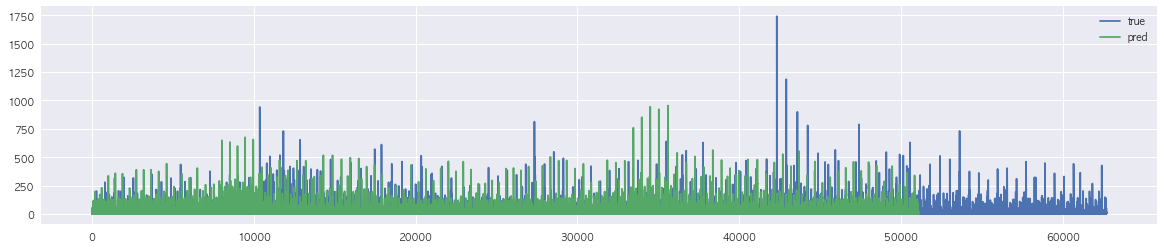

In [312]:
# visualize result 
plt.figure(figsize=(20,4))
plt.plot(y_test1[y_test1!=0], label='true')
plt.plot(y_pred1[y_test1[y_test1!=0].index].clip(0), label='pred')
plt.legend(loc = 'best')
plt.show()

In [278]:
MAPE(y_test1, y_pred1)

inf

In [237]:
shap_values1

array([[ 0.11165608,  0.17795041, -0.0234158 , ..., -0.00186726,
         0.        ,  0.        ],
       [ 0.14023626,  0.18126868, -0.02545833, ..., -0.00173261,
         0.        ,  0.        ],
       [ 0.10568679, -0.0174286 , -0.00770713, ..., -0.00051829,
         0.        ,  0.        ],
       ...,
       [-0.11866867, -0.14718685,  0.00262611, ...,  0.0569438 ,
         0.        ,  0.        ],
       [-0.10396933, -0.14768729,  0.00187291, ...,  0.0569438 ,
         0.        ,  0.        ],
       [-0.07898468, -0.14108334,  0.00112484, ...,  0.0569438 ,
         0.        ,  0.        ]], dtype=float32)

In [238]:
shap_values1.shape

(377487, 129)

In [216]:
def feature_importance(f) : 
    f = f.reset_index()
    feature_importance = f.sort_values(by='feature importance', ascending=False)

    fig, ax = plt.subplots(figsize=(8,10))
    plot = sns.barplot(
                data = feature_importance[:50],
                x = "feature importance",
                y = "col", 
                palette=("Blues_d")
            )

    for p in plot.patches:
        x, y, width, height = p.get_bbox().bounds
        plot.text(width*1.01, y+height/2, width, va='center')

In [221]:
# xgboost 
y_true0, y_pred0, f0 = location_ensemble(bty_c0, xgb.XGBRegressor(learning_rate=0.3, max_depth=5, n_estimators=100))

===== Finish Data Preprocessing =====



ValueError: operands could not be broadcast together with shapes (62709,) (33,) (62709,) 

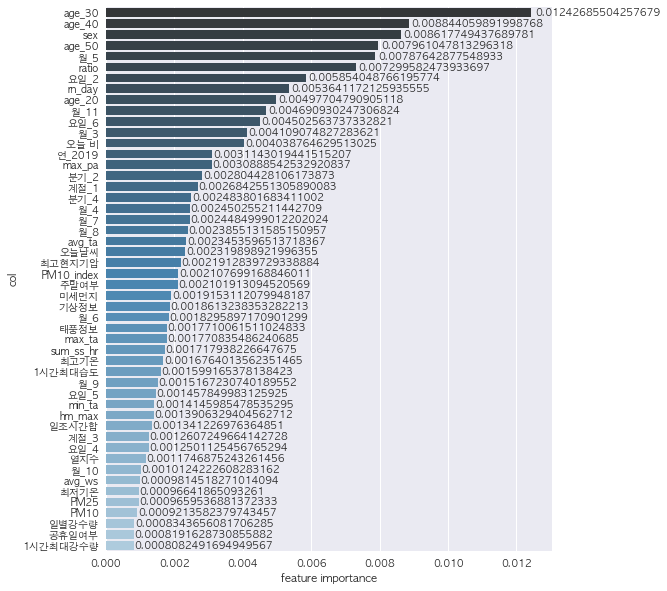

In [217]:
feature_importance(f0)